Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import missingno as msno
from pandas_profiling import ProfileReport
from sklearn import decomposition
from sklearn import preprocessing
from scipy.stats import linregress as reg_lin

## Gestion des paramètres d'affichage de Jupyter

In [82]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 165 sur ma config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Notes

Gross floor area (GFA) - The total floor area contained within the building measured to the external face of the external walls. Mesuré en square feet.  

1 sq foot = 0.092 m²  

ENERGYSTARScore : score de 1 à 100. Le score correspond au centile dans lequel le bâtiment se trouve.  

Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area.  

1 acre = 4047 m²  

1 British thermal unit (kBtu) per square foot = 3.2 kW.h/m²  

1 kBtu = 0.29 kW.h  

SPD beats : rondes de la police (SPD = Seattle PD)

WN : weather normalized

# Récupération des données pour 2015 et 2016

## Lecture des fichiers .json (metadata)

### Fichier pour 2015

#### Affichage intégral du json :

In [83]:
with open('socrata_metadata_2015-building-energy-benchmarking.json') as f:
  df2015metadata = json.load(f)
print(json.dumps(df2015metadata, indent = 4, sort_keys=False))

{
    "id": "h7rm-fz6m",
    "name": "2015 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "http://www.seattle.gov/environment",
    "averageRating": 0,
    "createdAt": 1492461362,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\r\nPer Ordinance (125000), starting 

Sections du json :

In [84]:
df2015metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [85]:
nbcol = len(df2015metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 47


In [86]:
for column in range(len(df2015metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [87]:
Liste_var_2015 = []
for column in range(nbcol):
    name = df2015metadata["columns"][column]['name']
    Liste_var_2015.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2015metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Description non disponible
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name.
********** Colonne 5 : TaxParcelIdentificationNumber **********
	
Property King County PIN
********** Colonne 6 : Location **********
Description non disponible
********** Colonne 7 : CouncilDistrictCode **********
Property City of Seattle council district.
********** Colonne 8 : Neighborhood **********

### Fichier pour 2016

#### Affichage intégral du json :

In [88]:
with open('socrata_metadata_2016-building-energy-benchmarking.json') as f:
  df2016metadata = json.load(f)
print(json.dumps(df2016metadata, indent = 4, sort_keys=False))

{
    "id": "2bpz-gwpy",
    "name": "2016 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "https://www.seattle.gov/energybenchmarking",
    "averageRating": 0,
    "createdAt": 1521070051,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\nPer Ordinance (125000), sta

Sections du json :

In [89]:
df2016metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowIdentifierColumnId', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [90]:
nbcol = len(df2016metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 46


In [91]:
for column in range(len(df2016metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [92]:
Liste_var_2016 = []
for column in range(nbcol):
    name = df2016metadata["columns"][column]['name']
    Liste_var_2016.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2016metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Calendar year (January-December) represented by each data record.
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name as entered in EPA’s Portfolio Manager.
********** Colonne 5 : Address **********
Property street address
********** Colonne 6 : City **********
Property city
********** Colonne 7 : State **********
Property state
********** Colonne 8 : ZipCode **********
Property zi

### Différences entre les variables de 2015 et 2016

Listes des variables de 2015, de 2016, et concaténation de ces deux listes

In [93]:
liste_var_2015_2016 = Liste_var_2016 + Liste_var_2015
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_var_2015_2016 = list(dict.fromkeys(liste_var_2015_2016))
# impression des variables et des années de disponibilité
for var in liste_var_2015_2016:
    print(var, end=' : ')
    if var in Liste_var_2015:
        print(" 2015", end='')
    if var in Liste_var_2016:
        print(" 2016", end='')
    print()

OSEBuildingID :  2015 2016
DataYear :  2015 2016
BuildingType :  2015 2016
PrimaryPropertyType :  2015 2016
PropertyName :  2015 2016
Address :  2016
City :  2016
State :  2016
ZipCode :  2016
TaxParcelIdentificationNumber :  2015 2016
CouncilDistrictCode :  2015 2016
Neighborhood :  2015 2016
Latitude :  2016
Longitude :  2016
YearBuilt :  2015 2016
NumberofBuildings :  2015 2016
NumberofFloors :  2015 2016
PropertyGFATotal :  2015 2016
PropertyGFAParking :  2015 2016
PropertyGFABuilding(s) :  2015 2016
ListOfAllPropertyUseTypes :  2015 2016
LargestPropertyUseType :  2015 2016
LargestPropertyUseTypeGFA :  2015 2016
SecondLargestPropertyUseType :  2015 2016
SecondLargestPropertyUseTypeGFA :  2015 2016
ThirdLargestPropertyUseType :  2015 2016
ThirdLargestPropertyUseTypeGFA :  2015 2016
YearsENERGYSTARCertified :  2015 2016
ENERGYSTARScore :  2015 2016
SiteEUI(kBtu/sf) :  2015 2016
SiteEUIWN(kBtu/sf) :  2015 2016
SourceEUI(kBtu/sf) :  2015 2016
SourceEUIWN(kBtu/sf) :  2015 2016
SiteEnerg

## Conversion des fichiers .csv en dataframe pandas

In [94]:
df2015 = pd.read_csv('2015-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)

df2016 = pd.read_csv('2016-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)


### Création des colonnes Latitude et Longitude pour le df2015

In [95]:
import ast     
df2015["Latitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['latitude']))     # ast.literal_eval(x) convertit le string x en dictionnaire
df2015["Longitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['longitude'])) 

In [96]:
df2015["Latitude"][0]

47.61219025

## Affichage de quelques lignes des dataframes

In [97]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(df2015.head())
#     display(df2015.loc[[4]])
#     display(df2015.loc[4:5000])
    display(df2015.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.612190,-122.337997
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.613106,-122.333358
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081,47.613349,-122.337699
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081,47.614216,-122.336609
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576,47.613754,-122.340924


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude
3335,50049,2015,Multifamily LR (1-4),Low-Rise Multifamily,PACIFIC CENTER CONDOMINIUM,6599950000,"{'latitude': '47.59950256', 'longitude': '-122.32034302', 'human_address': '{""address"": ""321 10TH AVE S"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98104""}'}",2,DOWNTOWN,2000,1,4.0,44650,0,44650,Multifamily Housing,Multifamily Housing,44650.0,NaN,NaN,NaN,NaN,NaN,71.0,25.6,27.8,80.4,87.2,1142949.0,1240429.0,0.0,334979.0,1142996.0,0.0,0.0,0.0,7.97,0.07,No,NaN,Compliant,NaN,NaN,26.0,NaN,16.0,18379,47.599503,-122.320343
3336,50055,2015,Multifamily MR (5-9),Mid-Rise Multifamily,IDENTITY APTS 4123,1142001670,"{'latitude': '47.65752471', 'longitude': '-122.3160159', 'human_address': '{""address"": ""4123 12TH AVE NE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98105""}'}",4,NORTHEAST,2014,1,7.0,42393,0,42393,Multifamily Housing,Multifamily Housing,31748.0,NaN,NaN,NaN,NaN,NaN,98.0,48.6,55.1,124.2,144.7,1543282.0,1750143.0,0.0,325705.0,1111352.0,4320.0,431976.0,0.0,30.69,0.61,No,NaN,Compliant,NaN,NaN,60.0,NaN,38.0,18383,47.657525,-122.316016
3337,50057,2015,Multifamily HR (10+),High-Rise Multifamily,CIRRUS,660000575,"{'latitude': '47.61649845', 'longitude': '-122.33770787', 'human_address': '{""address"": ""2030 8TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,2015,1,40.0,319481,41915,277566,"Multifamily Housing, Parking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,52.7,61.4,93.1,102.2,16834414.0,19623362.0,0.0,1690364.0,5767761.0,110669.0,11066893.0,0.0,627.97,1.89,No,NaN,Compliant,NaN,NaN,56.0,NaN,7.0,19576,47.616498,-122.337708
3338,50058,2015,Multifamily LR (1-4),Low-Rise Multifamily,WEDGEWOOD ESTATES BLDG A,6392001040,"{'latitude': '47.68396954', 'longitude': '-122.2874088', 'human_address': '{""address"": ""3801 NE 77TH ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98115""}'}",4,NORTHEAST,1981,1,3.0,48230,0,48230,Multifamily Housing,Multifamily Housing,22310.0,NaN,NaN,NaN,NaN,NaN,44.0,34.8,38.1,109.4,119.5,777064.0,849250.0,0.0,227744.0,777096.0,0.0,0.0,0.0,5.42,0.04,No,NaN,Compliant,NaN,NaN,55.0,NaN,48.0,18792,47.683970,-122.287409
3339,50059,2015,Multifamily LR (1-4),Low-Rise Multifamily,WEDGEWOOD ESTATES BLDG B,6392001040,"{'latitude': '47.68396954', 'longitude': '-122.2874088', 'human_address': '{""address"": ""7540 37TH AVE NE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98115""}'}",4,NORTHEAST,1981,1,4.0,53100,0,53100,Multifamily Housing,Multifamily Housing,25265.0,NaN,NaN,NaN,NaN,NaN,24.0,38.2,41.7,120.1,130.9,966376.0,1053118.0,0.0,283229.0,966416.0,0.0,0.0,0.0,6.74,0.05,No,NaN,Compliant,NaN,NaN,55.0,NaN,48.0,18792,47.683970,-122.287409


In [98]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(df2016.head())
#     display(df2016.loc[[4]])
#     display(df2016.loc[4:5000])
    display(df2016.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,153655.0000,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.0,116221.0000,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.0,525251.6875,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,102248.0000,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57
3375,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,2820 S Myrtle St,Seattle,WA,NaN,7857002030,2,GREATER DUWAMISH,47.53939,-122.29536,1938,1.0,1,18258,0,18258,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,NaN,63.099998,70.900002,115.800003,123.900001,1.152896e+06,1.293722e+06,0.0,126774.3984,4.325542e+05,7203.419922,7.203420e+05,False,NaN,Compliant,NaN,41.27,2.26


## Statistiques rudimentaires

In [99]:
length = len(df2015)
print("length df2015 =", length)
length = len(df2016)
print("length df2016 =", length)

length df2015 = 3340
length df2016 = 3376


In [100]:
df2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 49 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [101]:
df2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [102]:
df2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,1559.000000,560.000000,2560.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000,3340.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,27675.646568,10755.708929,67.894141,53.626126,57.586547,132.779730,138.936036,4.983106e+06,5.203055e+06,2.502851e+05,1.017897e+06,3.473209e+06,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240,47.624091,-122.335013
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,52480.843425,22618.529737,27.154057,53.893311,55.604963,131.943223,131.359121,1.375330e+07,1.400757e+07,3.481900e+06,2.789931e+06,9.519639e+06,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192,0.047924,0.027169
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000,47.499331,-122.413996
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,4959.000000,2385.250000,51.750000,27.300000,29.700000,73.500000,80.300000,9.139300e+05,9.883248e+05,0.000000e+00,1.864908e+05,6.363322e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000,47.599836,-122.350568
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,10600.000000,5019.500000,76.000000,37.400000,40.900000,95.000000,102.800000,1.776219e+06,1.953996e+06,0.000000e+00,3.400320e+05,1.160236e+06,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000,47.618496,-122.332712
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,26224.500000,10275.000000,90.000000,59.875000,65.575000,143.900000,151.275000,4.044277e+06,4.368462e+06,0.000000e+00,8.061935e+05,2.750847e+06,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000,47.657223,-122.319898
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.278697e+08,8.344505e+07,2.847263e+08,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000,47.733811,-122.220470


In [103]:
df2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


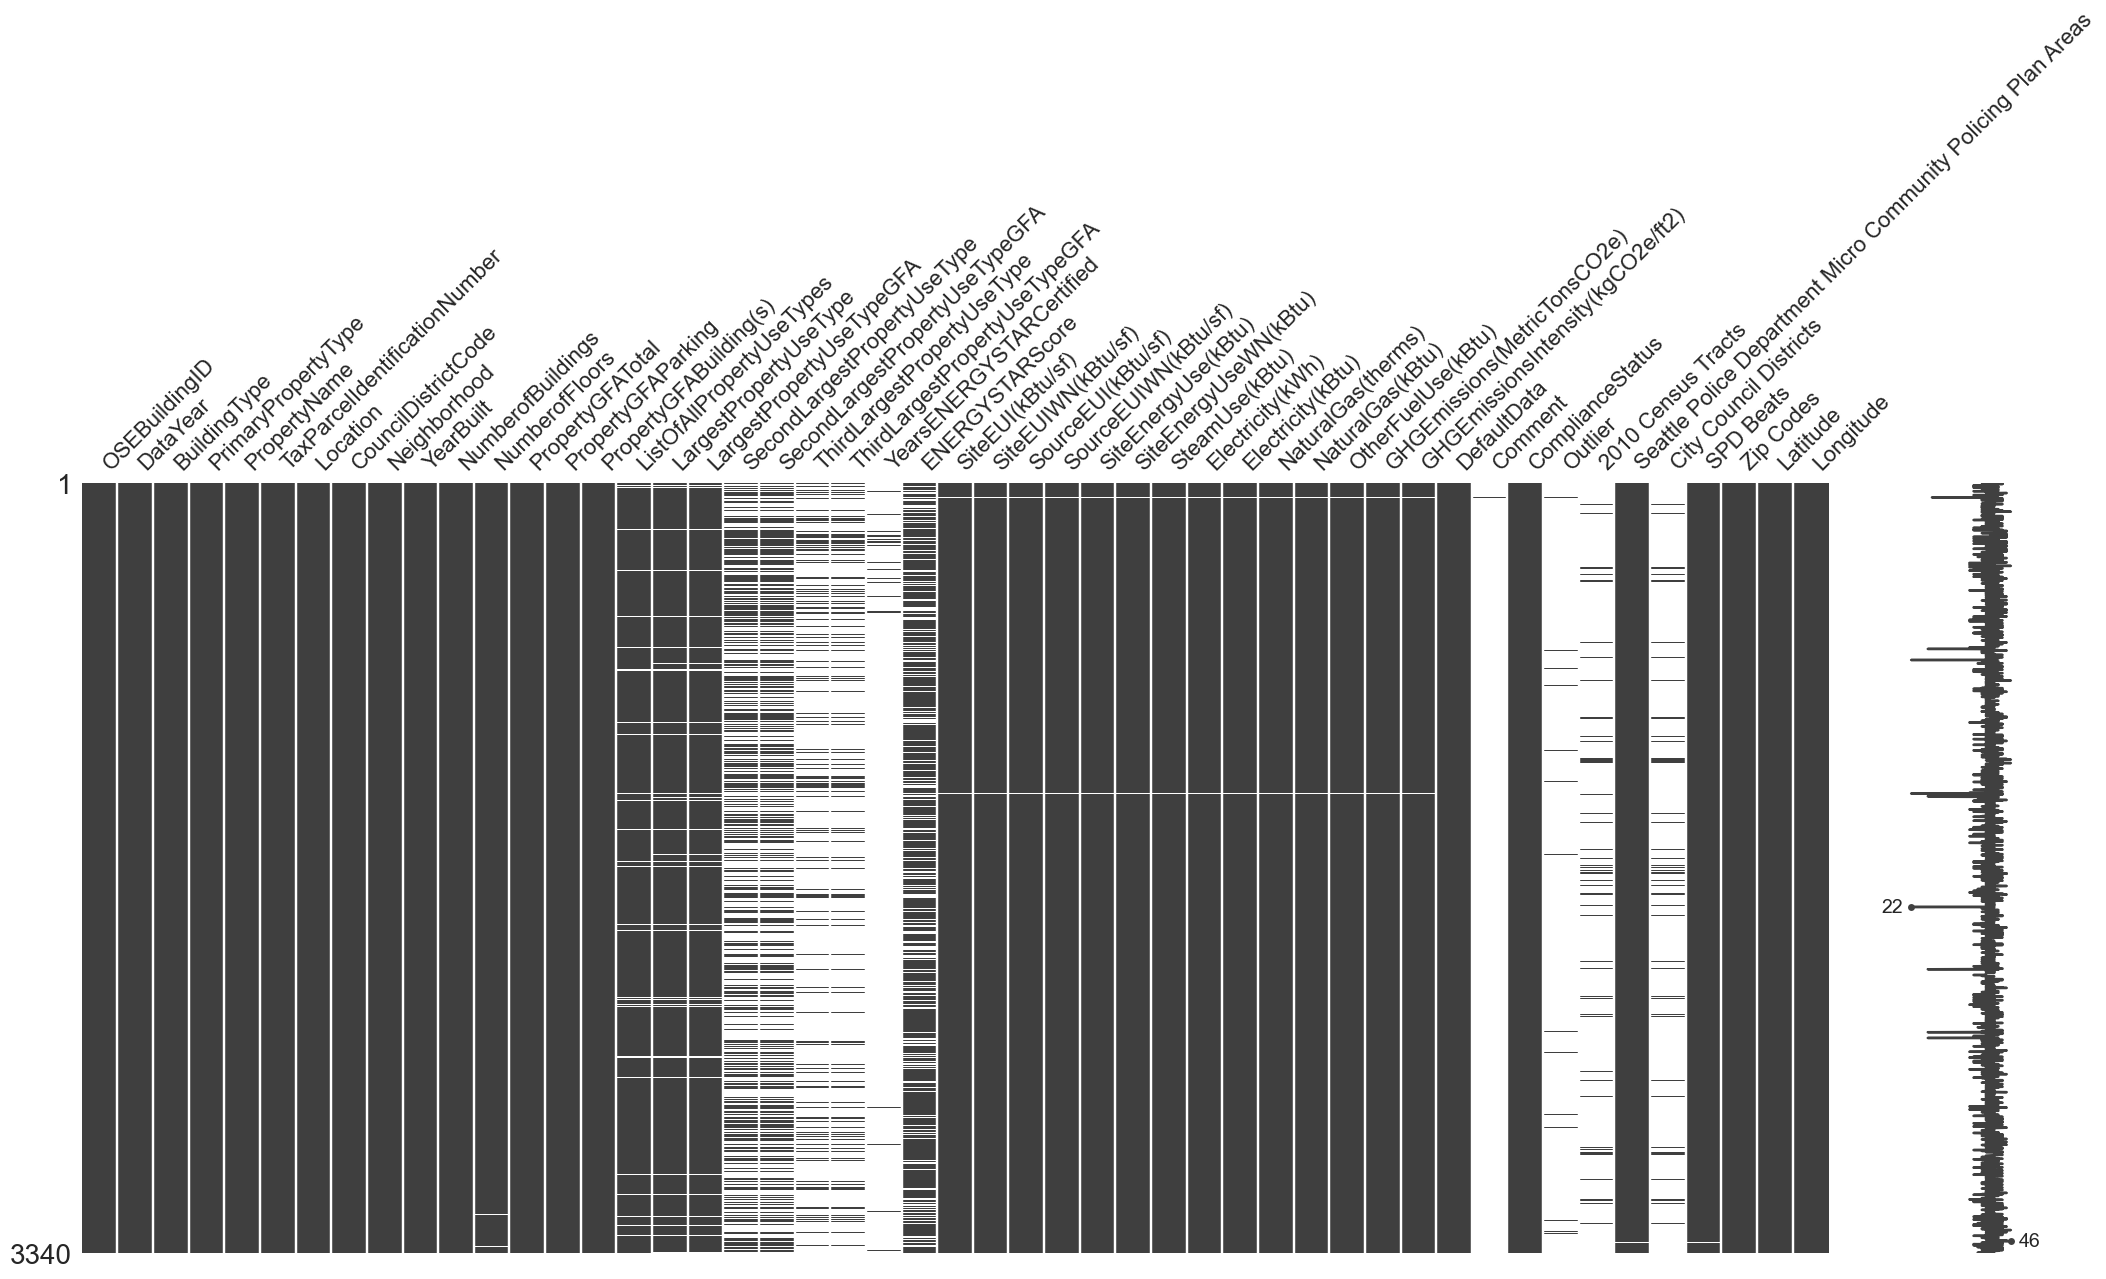

In [104]:
msno.matrix(df2015);

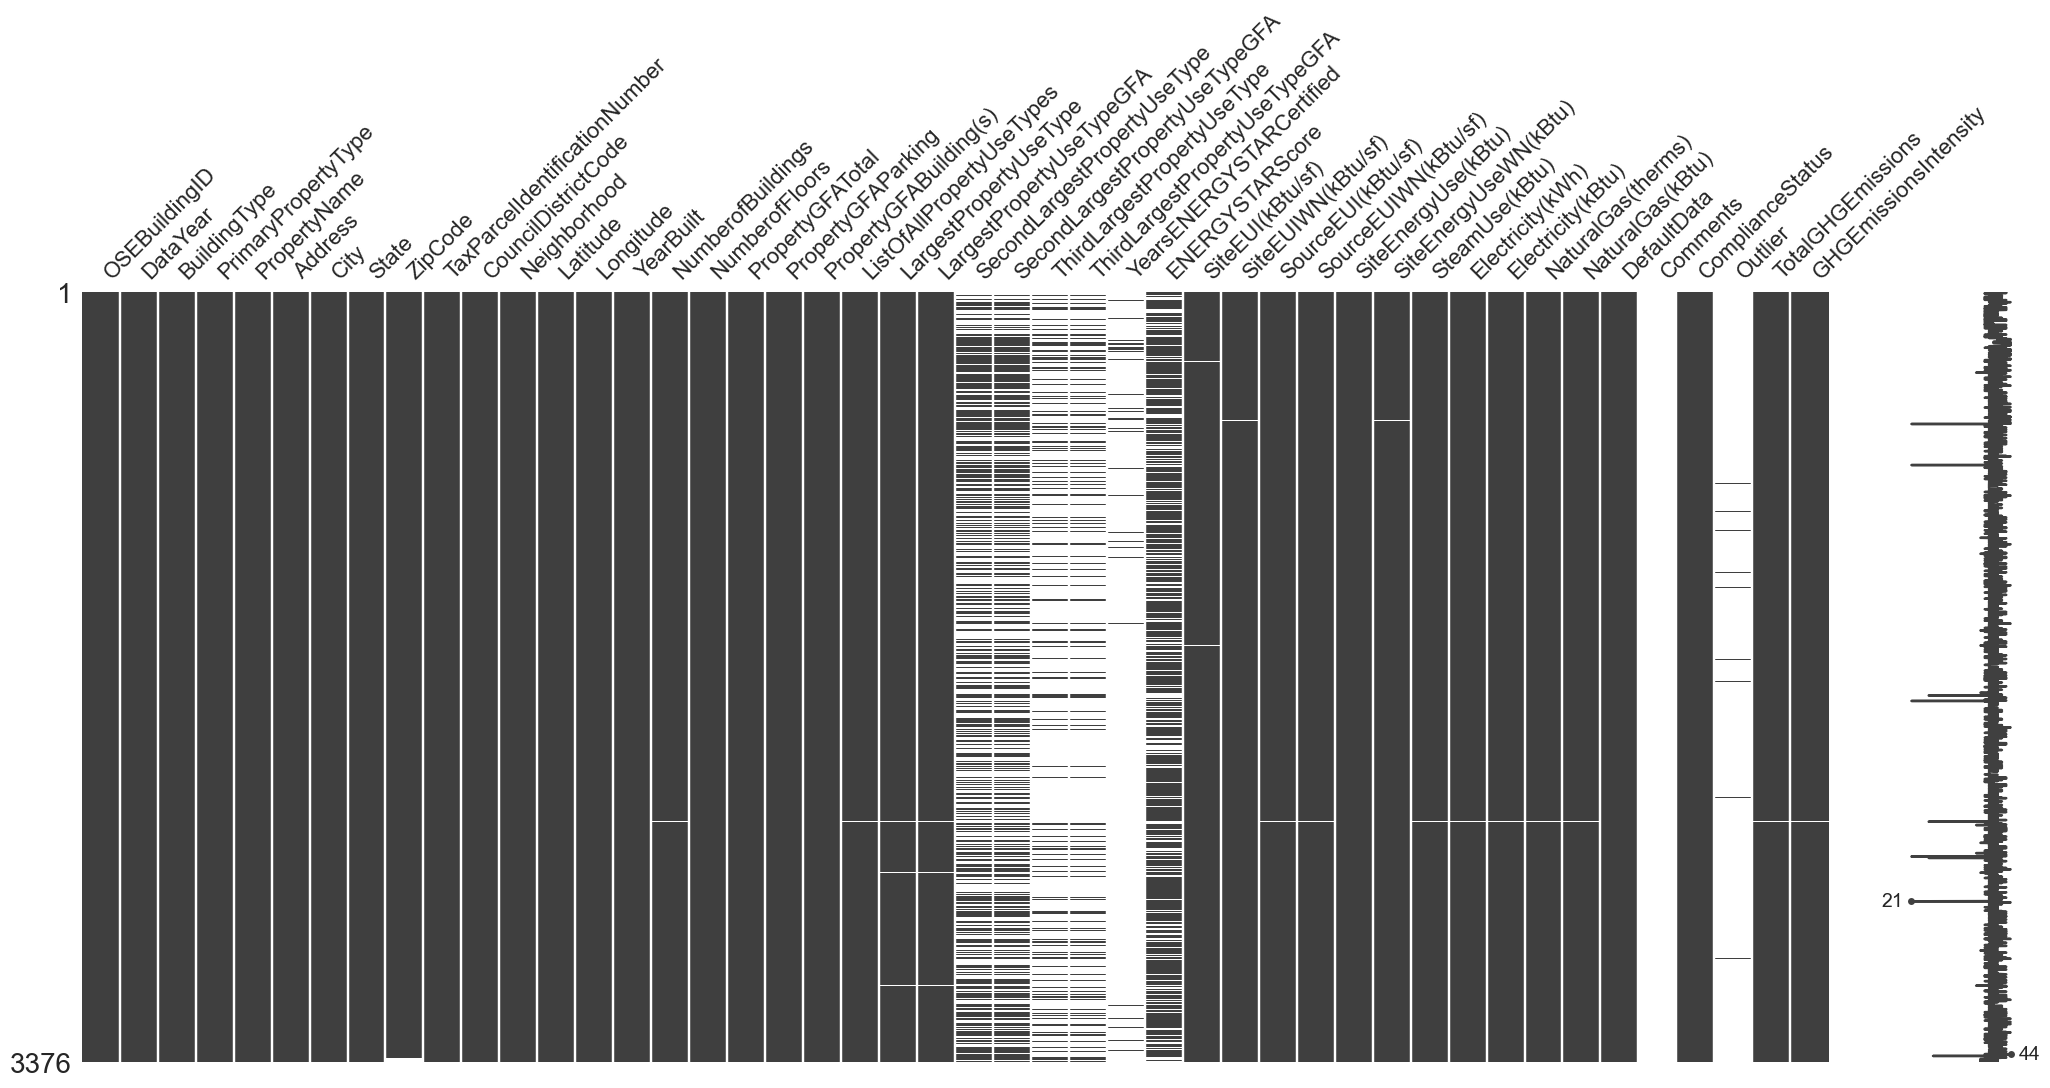

In [105]:
msno.matrix(df2016);

## Analyse exploratoire avec pandas_profiling (minimaliste)

In [106]:
profile = False
if profile:
    profile = ProfileReport(df2015, title='df2015 Pandas Profiling Report', minimal=True)
profile

False

In [107]:
profile = False
if profile:
    profile = ProfileReport(df2016, title='df2016 Pandas Profiling Report', minimal=True)
profile

False

In [108]:
Liste_var_supprimées = []

# Nettoyage de données

## Recherche de bâtiments en doublons

### Recherche de doublons intra 2015

In [109]:
len(df2015['OSEBuildingID'].unique())

3340

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2015, ce qui indique une absence de doublons.

### Recherche de doublons intra 2016

In [110]:
len(df2016['OSEBuildingID'].unique())

3376

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2016, ce qui indique une absence de doublons.

### Recouvrement entre les datasets de 2015 et 2016 ; et de la pertinence de travailler avec les deux datasets réunis

On compare les OSEBuildingID du df2015 avec ceux du df2016.

In [111]:
Set_OSEBuildingID_2015 = set(df2015['OSEBuildingID'])
Set_OSEBuildingID_2016 = set(df2016['OSEBuildingID'])

#### Union 2015 et 2016

In [112]:
len(Set_OSEBuildingID_2015 | Set_OSEBuildingID_2016)

3432

#### Intersection 2015 et 2016

In [113]:
len(Set_OSEBuildingID_2015 & Set_OSEBuildingID_2016)

3284

#### Bâtiments de 2015 non renseignés en 2016

In [114]:
len(Set_OSEBuildingID_2015 - Set_OSEBuildingID_2016)

56

#### Bâtiments de 2016 non renseignés en 2015

In [115]:
len(Set_OSEBuildingID_2016 - Set_OSEBuildingID_2015)

92

#### Conclusion sur le recouvrement

En joignant les datasets 2015 et 2016, on passerait de 3376 à 3432 bâtiments dans un nouveau dataset (soit un gain de 1.7%). Le gain en nb de bâtiments est trop faible pour prendre le risque de joindre des données qui ont disparu pour une raison non déterminée entre 2015 et 2016.  
Pour notre mission de prédiction de données, nous ne travaillerons donc qu'avec le dataset le plus récent : celui de 2016.

## Suppression de variables

### Variables disponibles dans les datasets de 2015 et 2016

In [116]:
liste_var_2015_2016

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Location

### Variables conservées

Raisons des suppressions de colonnes :
- modalité unique (DataYear, NumberofBuildings)
- modalité différente pour chaque bâtiment (PropertyName, TaxParcelIdentificationNumber, Location, )
- trop peu de bâtiments renseignés (YearsENERGYSTARCertified, ComplianceStatus, Outlier)
- non pertinent pour notre problème (DefaultData, Comment)
- data leakage ( / ) : donnée qu'on ne devra pas exploiter dans le jeu de test.

In [117]:
liste_var_conservees = [
    'OSEBuildingID',
    # 'DataYear',     # modalité unique
    'BuildingType',
    'PrimaryPropertyType',
    # 'PropertyName',     # modalité différente pour chaque bâtiment
    # 'Address',     # non pertinent
    # 'City',     # modalité unique
    # 'State',     # modalité unique
    'ZipCode',
    # 'TaxParcelIdentificationNumber',     # modalité différente pour chaque bâtiment
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    # 'ListOfAllPropertyUseTypes',     # trop de modalités différentes pour chaque bâtiment  # redondances
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA',
    # 'YearsENERGYSTARCertified',     # trop peu de bâtiments renseignés
    'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    # 'DefaultData',     # non pertinent
    # 'Comments',     # non pertinent
    # 'ComplianceStatus',     # non pertinent
    # 'Outlier',     # non pertinent
    'TotalGHGEmissions',
    'GHGEmissionsIntensity',
    # 'Location',     # issu du dataset 2015. ; substitué par Longitude/Latitude
    # 'OtherFuelUse(kBtu)',     # non pertinent
    # 'GHGEmissions(MetricTonsCO2e)',     # issu du dataset 2015. Renommé TotalGHGEmissions dans le dataset 2016
    # 'GHGEmissionsIntensity(kgCO2e/ft2)',     # issu du dataset 2015. Renommé GHGEmissionsIntensity dans le dataset 2016
    # 'Comment',     # non pertinent
    # '2010 Census Tracts',          # non pertinent
    # 'Seattle Police Department Micro Community Policing Plan Areas',          # non pertinent
    # 'City Council Districts',     # issu du dataset 2015. Renommé CouncilDistrictCode dans le dataset 2016
    # 'SPD Beats'          # non pertinent
]

### Création de df1 (données de 2016 avec uniquement les variables conservées)

In [118]:
df1 = pd.DataFrame()
for var in liste_var_conservees:
    df1[var] = df2016[var]

In [119]:
df1

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,NaN,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,12294.0,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,1.70
3372,50223,Nonresidential COS,Other,NaN,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01
3373,50224,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,NaN,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,1.57


## Suppression des bâtiments destinés à l’habitation 

### Exploration des variables qui classent le type de bâtiment

Notes : 
- SPS : Seattle Public schools  


In [120]:
df1['BuildingType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False)

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [121]:
df1['PrimaryPropertyType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [122]:
df1['LargestPropertyUseType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Medical Office                                            41
Supermarket/Grocery Store                                 41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
Residence Hall/Dormitory

### Suppression via la variable 'BuildingType'

In [123]:
# Suppression des modalités 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'
ser_bool = (df1['BuildingType'] == 'Multifamily LR (1-4)') | (df1['BuildingType'] == 'Multifamily MR (5-9)') | (df1['BuildingType'] == 'Multifamily HR (10+)')
df1 = df1[~ser_bool]

In [124]:
df1

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,NaN,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,12294.0,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,1.70
3372,50223,Nonresidential COS,Other,NaN,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01
3373,50224,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,NaN,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,1.57


## Suppression de valeurs zéro

Plusieurs variables qui ne peuvent pas être nulles contiennent des valeurs à zéro.  
La liste suivante contient les variables que nous allons nettoyer.  
Les valeurs à zéro ont été remplacées par des NaN.

In [125]:
liste_var_nettoyees_zero = [
    'PropertyGFATotal',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
]

Exécution du nettoyage

In [126]:
print(
    'Variable'.center(36, ' '), 
    'Nb de valeurs avant nettoyage'.center(33, ' '), 
    'Nb de remplacements NaN'.center(25, ' '), 
    '%remplacés'.center(11, ' '))
print(''.center(36+33+25+11+4, '-'))

for var in liste_var_nettoyees_zero:
    count_avant = df1[var].count()
    df1[var] = df1[var].apply(lambda x: np.nan if x == 0 else x)
    count_apres = df1[var].count()
    print(
        var.center(36, ' '),
        str(count_avant).center(33, ' '),
        str(count_avant - count_apres).center(25, ' '), 
        "{0:.2f}%".format((count_avant - count_apres) / count_avant * 100).center(11, ' '))

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          1668                           0                0.00%   
     LargestPropertyUseTypeGFA                      1662                           0                0.00%   
  SecondLargestPropertyUseTypeGFA                   855                            80               9.36%   
   ThirdLargestPropertyUseTypeGFA                   353                            24               6.80%   
          SiteEUI(kBtu/sf)                          1665                           15               0.90%   
         SiteEUIWN(kBtu/sf)                         1665                           25               1.50%   
         SourceEUI(kBtu/sf)                         1666                           18               1.08%   
        SourceEUIW

<ipython-input-126-dd033f238572>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[var] = df1[var].apply(lambda x: np.nan if x == 0 else x)


## Remarque sur le traitement des valeurs atypiques (outliers)

A ce stade, je choisis de ne pas réaliser de traitement sur les valeurs atypiques (Z-scores élevés).  
Je compte les conserver et que les traitements soient réalisés lors du preprocessing/scaling (avec sklearn) par divers scalers.

## Imputations

# Analyse exploratoire de df1

## Analyse exploratoire avec pandas_profiling

In [127]:
profile = False
if profile:
    profile = ProfileReport(df1, title='Données 2016 filtrées Pandas Profiling Report', minimal=True)
profile

False

## Histogrammes

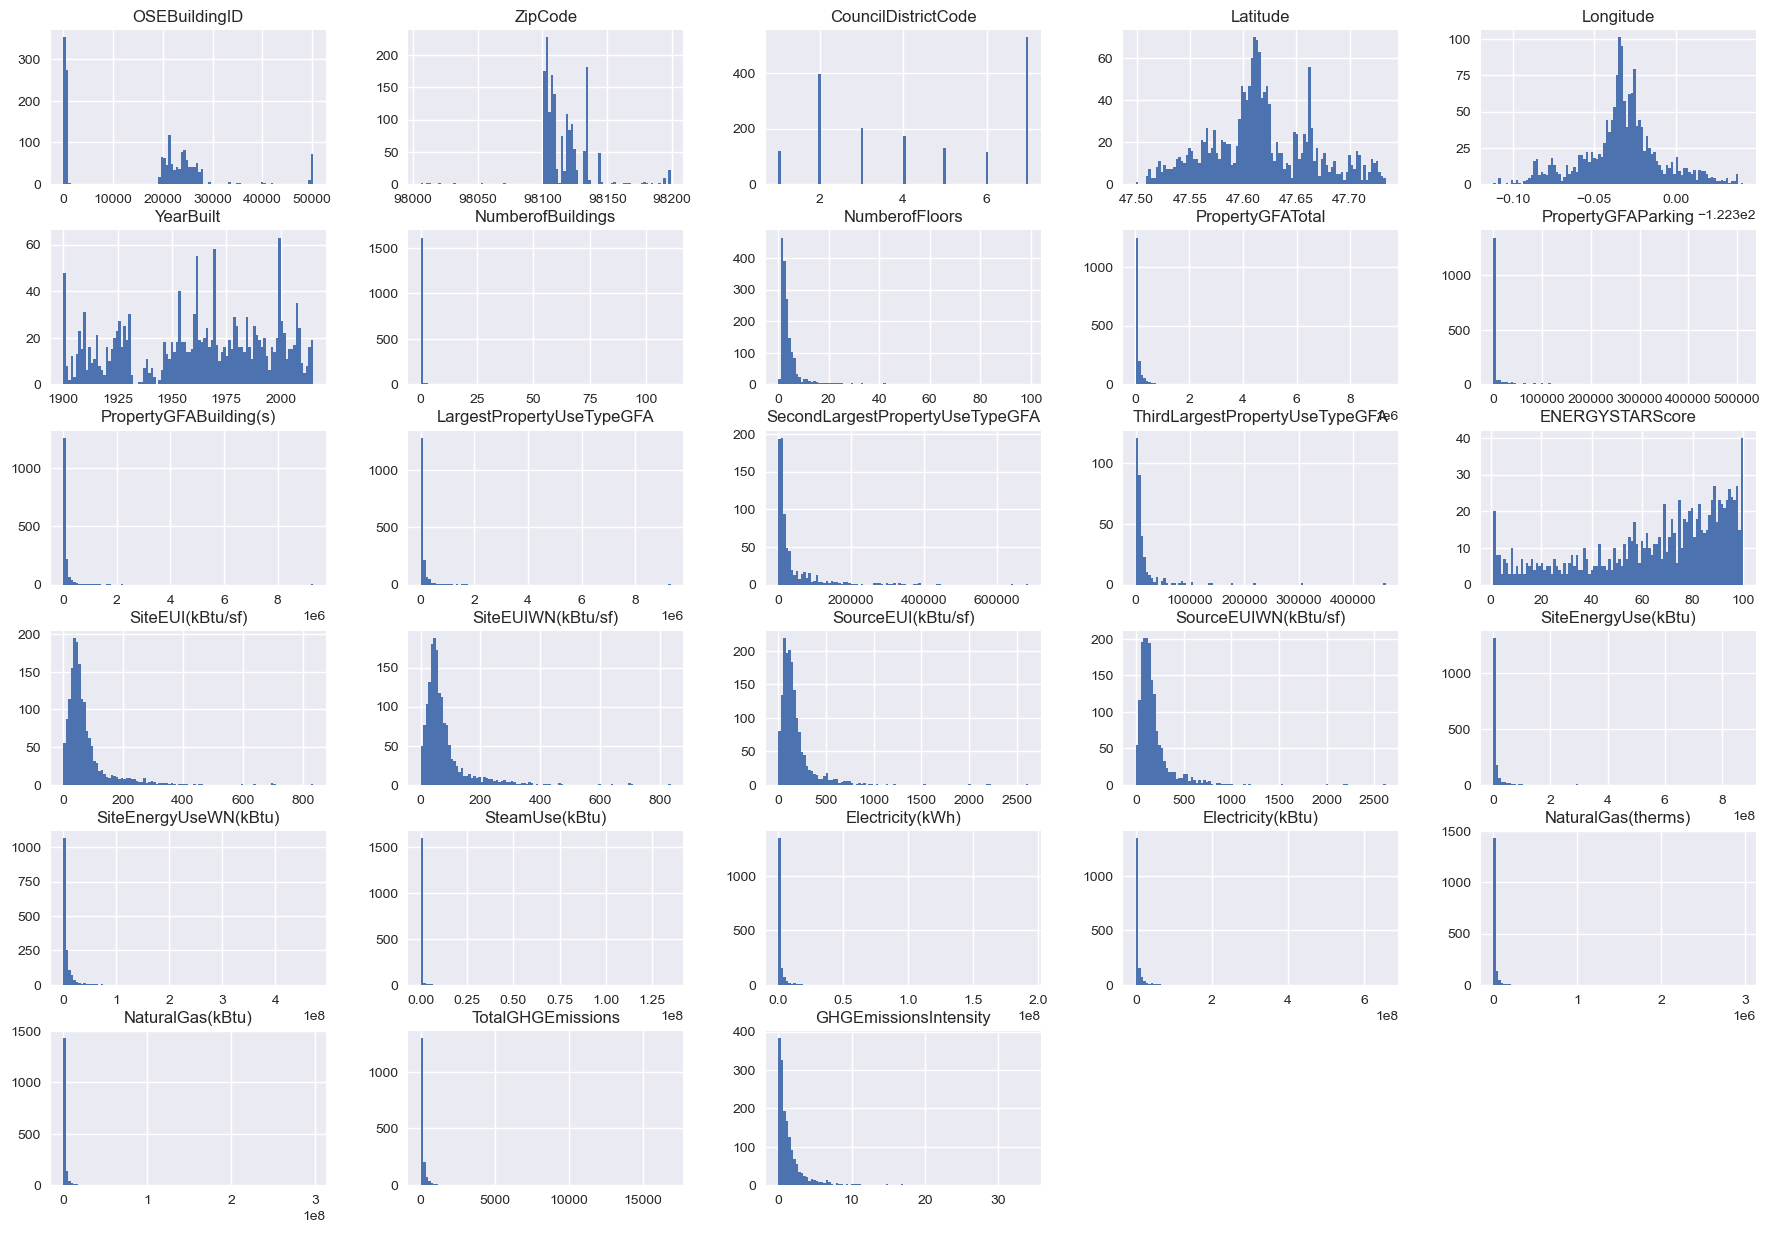

In [147]:
plt.style.use('seaborn')
df1.hist(bins=100, figsize=(22,15))
plt.show()

## Matrice de corrélation (heatmap)

In [129]:
df_corr = df1.corr()
print("Matrice de corrélation :")
display(df_corr)

Matrice de corrélation :


,OSEBuildingID,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,1.000000,0.136823,-0.163692,0.032358,0.093759,-0.003484,0.046140,-0.252541,-0.149523,-0.217268,-0.124125,-0.112434,-0.232428,-0.159483,-0.047328,-0.008460,-0.004273,-0.048181,-0.047627,-0.089423,-0.186088,-0.011553,-0.100153,-0.100153,-0.073453,-0.073453,-0.074462,0.084478
ZipCode,0.136823,1.000000,-0.191513,0.000221,-0.014638,0.096800,-0.014958,-0.144742,-0.059472,-0.096514,-0.047862,-0.041160,-0.053851,-0.011168,-0.000939,-0.064709,-0.069510,-0.057446,-0.062297,-0.048971,-0.056616,-0.049473,-0.047294,-0.047294,-0.024403,-0.024403,-0.053274,-0.069757
CouncilDistrictCode,-0.163692,-0.191513,1.000000,0.527574,-0.332862,-0.048781,-0.017283,0.277981,0.108981,0.193338,0.085266,0.069023,0.162041,0.015616,0.097383,0.079622,0.075309,0.106880,0.106583,0.048816,0.069789,0.008007,0.074257,0.074257,-0.009757,-0.009757,0.012391,-0.003264
Latitude,0.032358,0.000221,0.527574,1.000000,-0.092595,0.066119,0.020543,-0.009711,0.006030,0.038992,0.000509,0.006409,0.002154,-0.128951,0.040510,0.089395,0.088095,0.087223,0.087099,0.010457,-0.007422,-0.004994,0.011338,0.011338,0.001723,0.001723,0.000500,0.040671
Longitude,0.093759,-0.014638,-0.332862,-0.092595,1.000000,0.016216,0.020779,-0.013360,0.021227,-0.027642,0.026321,0.029736,0.024763,0.040063,0.002200,-0.020419,-0.020655,-0.023033,-0.023280,0.033090,0.024697,0.021025,0.022949,0.022949,0.035905,0.035905,0.040088,0.003814
YearBuilt,-0.003484,0.096800,-0.048781,0.066119,0.016216,1.000000,-0.030527,0.094417,0.102894,0.277118,0.066436,0.069556,0.275610,0.166575,-0.033748,0.126278,0.120614,0.161315,0.159221,0.064116,0.133071,-0.004016,0.073984,0.073984,0.057145,0.057145,0.049812,-0.010835
NumberofBuildings,0.046140,-0.014958,-0.017283,0.020543,0.020779,-0.030527,1.000000,-0.023349,0.734529,-0.011622,0.770237,0.796707,0.183669,-0.002798,-0.035865,0.027107,0.053262,0.024538,0.041245,0.713102,0.244655,0.408554,0.757527,0.757527,0.062233,0.062233,0.418477,0.025961
NumberofFloors,-0.252541,-0.144742,0.277981,-0.009711,-0.013360,0.094417,-0.023349,1.000000,0.406001,0.503449,0.349902,0.334182,0.485442,0.251949,0.121438,0.022297,0.014809,0.062015,0.059356,0.219479,0.319205,0.092870,0.282009,0.282009,0.034827,0.034827,0.129985,-0.048526
PropertyGFATotal,-0.149523,-0.059472,0.108981,0.006030,0.021227,0.102894,0.734529,0.406001,1.000000,0.375281,0.990450,0.977648,0.825036,0.526537,0.123219,0.035004,0.037398,0.054281,0.068315,0.809479,0.593175,0.452780,0.861831,0.861831,0.154318,0.154318,0.524564,-0.008973
PropertyGFAParking,-0.217268,-0.096514,0.193338,0.038992,-0.027642,0.277118,-0.011622,0.503449,0.375281,1.000000,0.243903,0.273127,0.465833,0.184383,0.093314,0.054474,0.048779,0.099714,0.097852,0.145410,0.209315,0.001400,0.201041,0.201041,0.028129,0.028129,0.058170,-0.091991


##### Représentation sous forme de heatmap

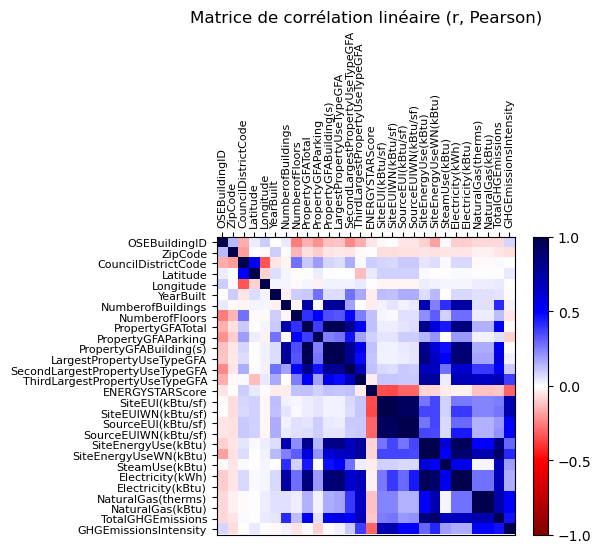

In [130]:
plt.style.use('default')
plt.matshow(df_corr, cmap='seismic_r', vmin=-1, vmax=1)
ticks = range(len(df_corr.columns))
plt.xticks(ticks,
           fontsize=8,
           labels=df_corr.columns,
           rotation=90)
plt.yticks(ticks, fontsize=8, labels=df_corr.columns)
plt.tick_params(bottom=False)
plt.colorbar(shrink=0.8, ticks=[-1, -0.5, 0, 0.5, 1])
plt.title('Matrice de corrélation linéaire (r, Pearson)')
plt.show()

##### Affichage des corrélations les plus fortes

In [131]:
df_corr_2 = pd.DataFrame(columns=['corrélation', 'var1', 'var2'])    # dataframe à 3 colonnes : 'corrélation', 'var1', 'var2'
for i in range(df_corr.shape[0]):
    for j in range(i):
        df_corr_2 = df_corr_2.append({'corrélation': df_corr.iloc[i,j], 'var1': df_corr.columns[i], 'var2': df_corr.columns[j]}, ignore_index=True)
df_corr_2 = df_corr_2.sort_values('corrélation', ascending=False, inplace=False)
df_corr_2 = df_corr_2.reset_index()
del df_corr_2['index']

In [132]:
df_corr_2.head(50)

,corrélation,var1,var2
0,1.000000,NaturalGas(kBtu),NaturalGas(therms)
1,1.000000,Electricity(kBtu),Electricity(kWh)
2,0.999427,SiteEnergyUseWN(kBtu),SiteEnergyUse(kBtu)
3,0.999251,SourceEUIWN(kBtu/sf),SourceEUI(kBtu/sf)
4,0.998815,SiteEUIWN(kBtu/sf),SiteEUI(kBtu/sf)
5,0.990450,PropertyGFABuilding(s),PropertyGFATotal
6,0.982238,LargestPropertyUseTypeGFA,PropertyGFABuilding(s)
7,0.977648,LargestPropertyUseTypeGFA,PropertyGFATotal
8,0.956248,Electricity(kWh),SiteEnergyUse(kBtu)
9,0.956248,Electricity(kBtu),SiteEnergyUse(kBtu)


In [133]:
df_corr_2.tail(10)

,corrélation,var1,var2
368,-0.191513,CouncilDistrictCode,ZipCode
369,-0.217268,PropertyGFAParking,OSEBuildingID
370,-0.232428,SecondLargestPropertyUseTypeGFA,OSEBuildingID
371,-0.252541,NumberofFloors,OSEBuildingID
372,-0.297997,GHGEmissionsIntensity,ENERGYSTARScore
373,-0.298536,SourceEUI(kBtu/sf),ENERGYSTARScore
374,-0.299792,SourceEUIWN(kBtu/sf),ENERGYSTARScore
375,-0.332862,Longitude,CouncilDistrictCode
376,-0.349977,SiteEUI(kBtu/sf),ENERGYSTARScore
377,-0.354204,SiteEUIWN(kBtu/sf),ENERGYSTARScore


On met à jour la liste des variables quantitatives en supprimant les variables fortement corrélées (r>0.99) :  

In [150]:
set_var_quanti_conservees = set(df_corr.columns) - {'NaturalGas(therms)', 'Electricity(kWh)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'PropertyGFATotal'}

La liste des variables qualitatives est la suivante :

In [175]:
set_var_quali = set(df1.columns) - set(df_corr.columns)
set_var_quali

{'BuildingType',
 'LargestPropertyUseType',
 'Neighborhood',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'}

## PCA

On analyse ici les corrélations entre les variables suivantes :  

In [152]:
print("Nb de variables :", len(set_var_quanti_conservees))
set_var_quanti_conservees

Nb de variables : 22


{'CouncilDistrictCode',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'Latitude',
 'Longitude',
 'NaturalGas(kBtu)',
 'NumberofBuildings',
 'NumberofFloors',
 'OSEBuildingID',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SteamUse(kBtu)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'YearBuilt',
 'ZipCode'}

In [162]:
# on utilise le code de Nicolas Rangeon (avec qques modifications mineures : critère de Kaiser, cercles non aplatis) disponible ici :
# https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp


def display_circles(pcs,
                    n_comp,
                    pca,
                    axis_ranks,
                    labels=None,
                    label_rotation=0,
                    lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            plt.style.use('seaborn')
            plt.figure(edgecolor='black', linewidth=4, figsize=(10, 10))

            # détermination des limites du graphique
            if lims == 'auto':
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(pcs[d1, :]), min(
                    pcs[d2, :]), max(pcs[d2, :])
            elif lims is not None:  # lims est un tuple
                xmin, xmax, ymin, ymax = lims
            else:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]),
                           np.zeros(pcs.shape[1]),
                           pcs[d1, :],
                           pcs[d2, :],
                           angles='xy',
                           scale_units='xy',
                           scale=1,
                           color="grey",
                           width=0.001)

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x,
                                 y,
                                 labels[i],
                                 fontsize='7',
                                 ha='center',
                                 va='center',
                                 rotation=label_rotation,
                                 color="blue",
                                 alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(
                d1 + 1, d2 + 1))
            plt.axis('square')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.show()


def display_factorial_planes(X_projected,
                             n_comp,
                             pca,
                             axis_ranks,
                             labels=None,
                             alpha=1,
                             illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            plt.style.use('seaborn')
            plt.figure(edgecolor='black', linewidth=4, figsize=(7, 6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2],
                            alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha,
                                label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x + 0.1,
                             y + 0.1,
                             labels[i],
                             fontsize='7',
                             ha='center',
                             va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection des individus (sur F{} et F{})".format(
                d1 + 1, d2 + 1))
            plt.show(block=False)


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_ * 100
    plt.style.use('seaborn')
    plt.figure(edgecolor='black', linewidth=4)
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.axhline(100/pca.n_features_, 0, len(pca.components_)+1, c='g', linewidth=0.3)  # critère de Kaiser
    plt.show(block=False)

##### Eboulis des valeurs propres

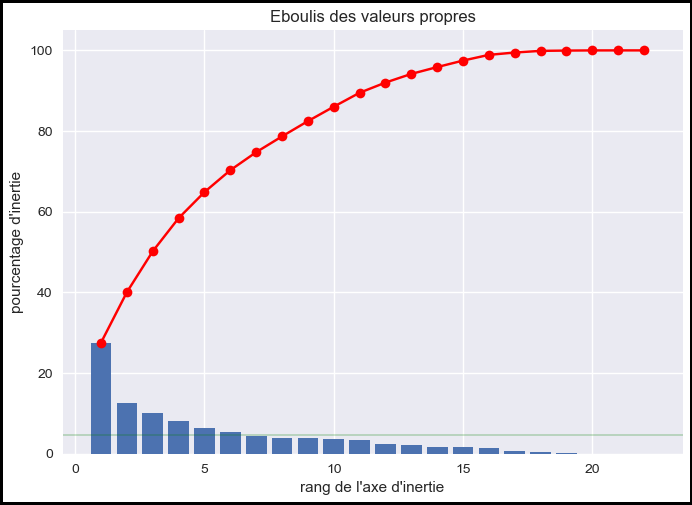

In [167]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = df1[set_var_quanti_conservees]

# choix du nombre de composantes pricipales à calculer
n_comp = 22

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean(
))  # remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

Interprétation de l'éboulis : 
- les variables sont modérément corrélées entre elles.
- en se basant sur le critère de Kaiser, matérialisé par le trait bleu horizontal (%inertie > 100/28), on ne représentera les cercles des corrélations que pour les 6 premières composantes (F1 à F6).

##### Cercles des corrélations

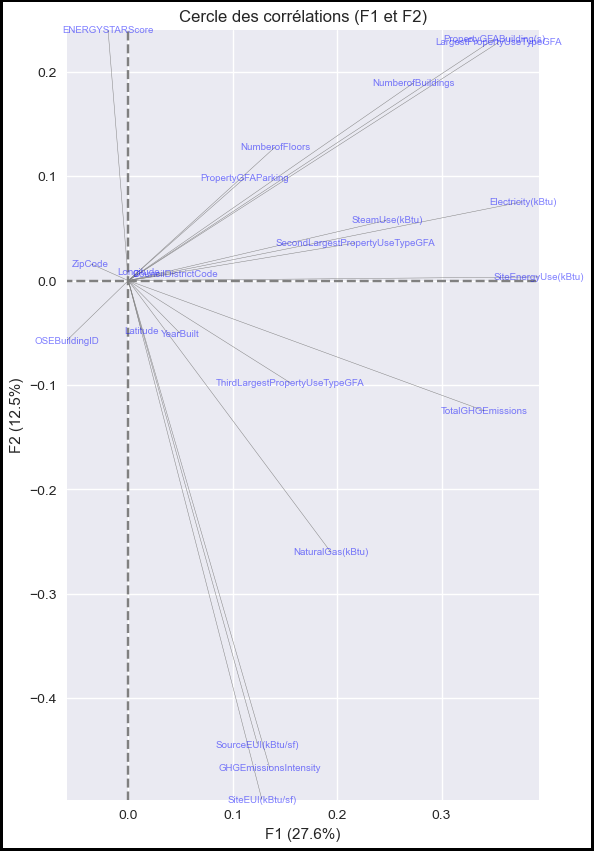

In [164]:
# Cercle des corrélations : premier plan factoriel
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features), lims='auto')

Interprétation du premier plan factoriel (F1 et F2) :  
- les variables les plus corrélées à F1 sont les variables corrélées à la quantité d'énergie consommée par bâtiment.
- les variables les plus corrélées à F2 sont les variables (anti)corrélées à la quantité d'énergie consommée par unité de surface.

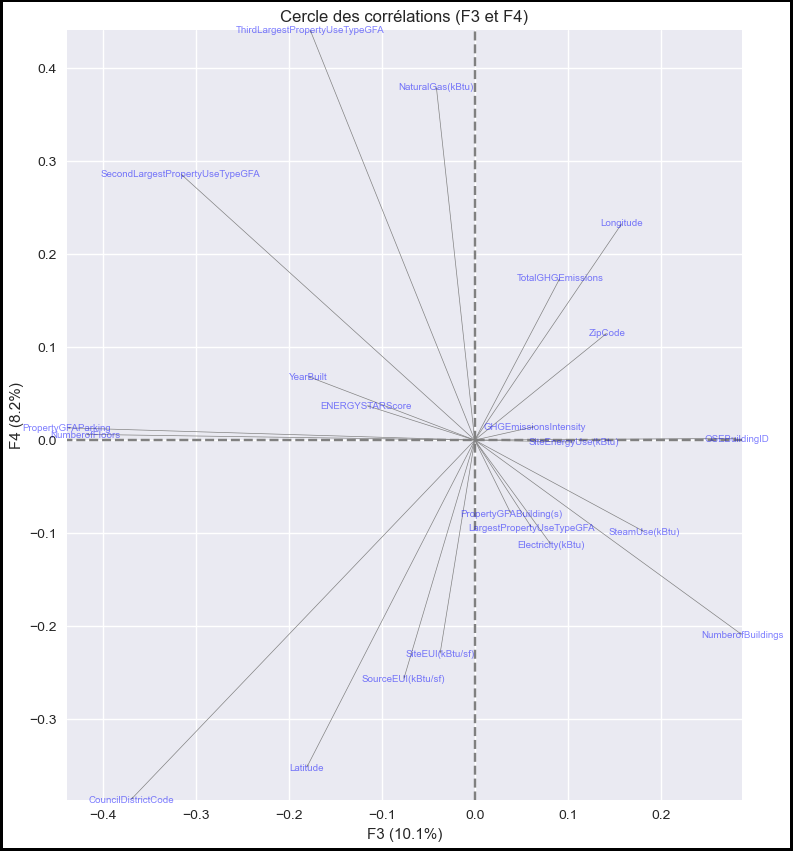

In [165]:
# Cercle des corrélations : second plan factoriel
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features), lims='auto')

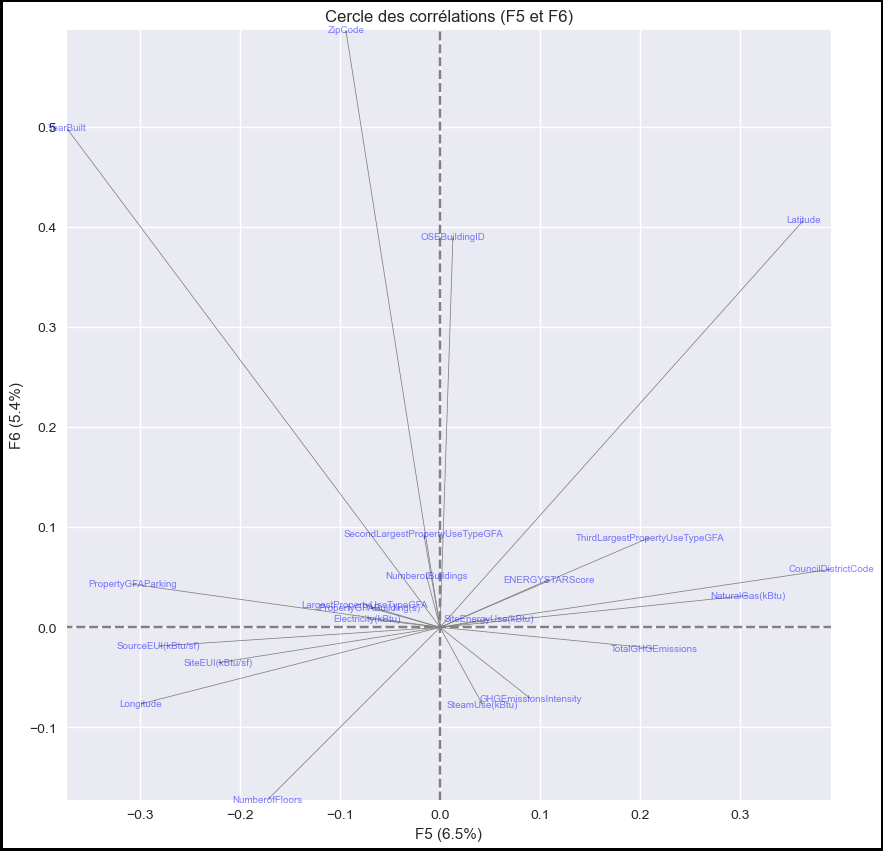

In [166]:
# Cercle des corrélations : 3è plan factoriel
display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features), lims='auto')

Interprétation du second plan factoriel (F3 et F4) et du troisième plan (F5 et F6) :  
- je ne vois pas comment on peut "interpréter" la signification de F3, F4, F5, F6.

## Scatter plots

### Fonction scatter_plot()

In [141]:
def scatter_plot(ser_x,
                 ser_y,
                 min_x=None,
                 max_x=None,
                 min_y=None,
                 max_y=None,
                 alpha=1.0,
                 unite_x=None,
                 unite_y=None):
    """ Retourne un scatter plot pour deux séries
    Args :
    - ser_x : série en abcisse.
    - ser_y : série en ordonnée.
    - min_x : valeur min représentée en abcisse.
    - max_x : valeur max représentée en abcisse.
    - min_y : valeur min représentée en ordonnée.
    - max_y : valeur max représentée en ordonnée.
    - alpha : transparence de chaque point.  
    - unite_x : string indiquant l'unité de la série en abcisse.  
    - unite_y : string indiquant l'unité de la série en ordonnée.        
    Returns : 
    - scatter plot + sa régression linéaire
    """
    
    # Calcul des arguments min_x, max_x, min_y, max_y s'ils sont None :
    if min_x is None:
        min_x = ser_x.min()
    if max_x is None:
        max_x = ser_x.max()
    if min_y is None:
        min_y = ser_y.min()
    if max_y is None:
        max_y = ser_y.max()
    
    # filtration des valeurs extrêmes. On exclue les valeurs à l'extérieur de l'intervalle [min_x, max_x], considérées comme aberrantes.
    largeur_x = max_x - min_x
    largeur_y = max_y - min_y

    def f_bool(x, min, max):
        if np.isnan(x):
            return False
        elif x < min:
            return False
        elif x > max:
            return False
        else:
            return True

    ser_x_bool = ser_x.apply(lambda x: f_bool(x, min_x, max_x)
                             )  # vaut True pour les valeurs non extrêmes
    ser_y_bool = ser_y.apply(lambda y: f_bool(y, min_y, max_y))
    ser_xy_bool = ser_x_bool & ser_y_bool  # vaut True pour les valeurs non extrêmes de ser_x et de ser_y, sinon vaut False
    # ser_x et ser_y sont les séries tracées
    ser_x = ser_x[ser_xy_bool]
    ser_y = ser_y[ser_xy_bool]
    total_count = ser_xy_bool.sum()

    # plotting scatter plot
    plt.style.use('seaborn')
    plt.figure(edgecolor='black', linewidth=4)
    plt.scatter(
        ser_x, ser_y, s=2,
        alpha=alpha)  # la valeur mini de alpha autorisée par pyplot est 0.002
    plt.xlabel(ser_x.name)
    plt.ylabel(ser_y.name)
    plt.title(label='Diagramme de dispersion (Effectif total = ' +
              str(int(total_count)) + ')')
    plt.ylim(min_y - largeur_y / 20, max_y + largeur_y / 20)
    label_x = ser_x.name if unite_x is None else ser_x.name + f" ({unite_x})"
    plt.xlabel(label_x)
    label_y = ser_y.name if unite_y is None else ser_y.name + f" ({unite_y})"
    plt.ylabel(label_y)

    # régression linéaire
    slope, intercept, r, p, std_err = reg_lin(ser_x, ser_y)
    model_x = pd.Series([min_x, max_x])
    model_y = slope * model_x + intercept
    plt.plot(model_x,
             model_y,
             color='r',
             linewidth=0.3,
             marker=None,
             linestyle='-')

    plt.annotate(
        text="Régression linéaire : y = {0:0.4f}*x + {1:0.4f}, R²={2:0.2f}".
        format(slope, intercept, r * r),
        xy=(min_x + largeur_x / 20, max_y - largeur_y / 20),
        color='red',
        size=10)
    plt.show()

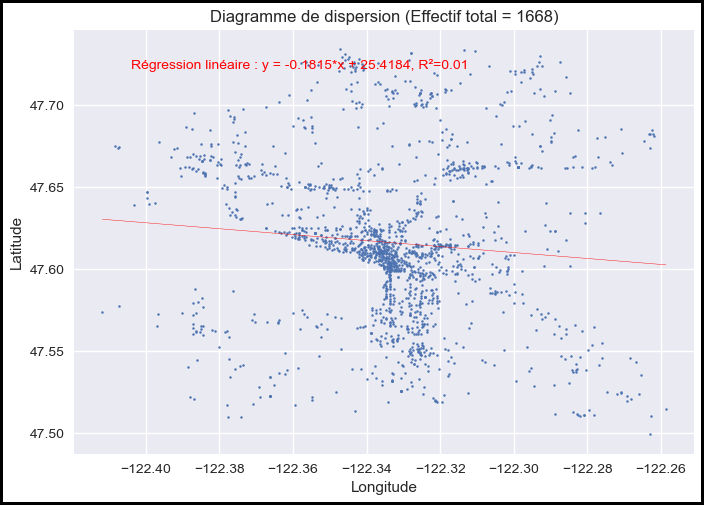

In [142]:
# test de scatter_plot()
scatter_plot(ser_x=df1['Longitude'], ser_y=df1['Latitude'])

### Variables avec r>0.99

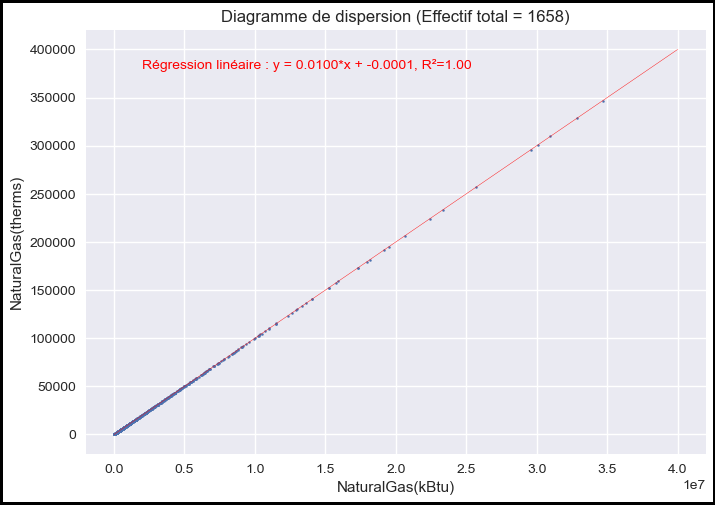

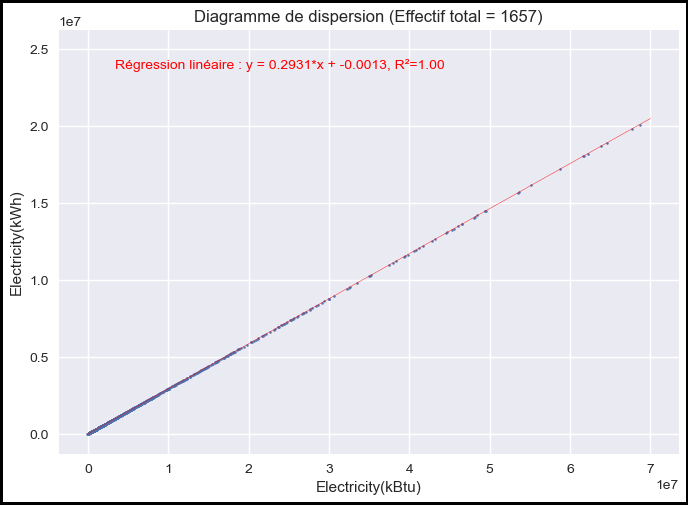

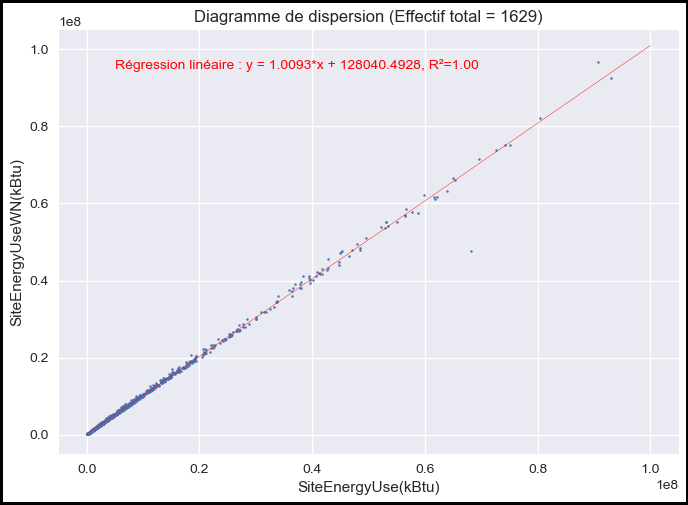

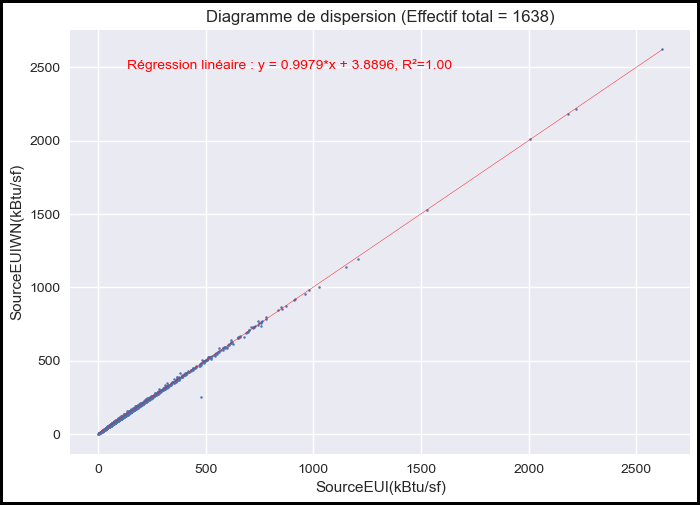

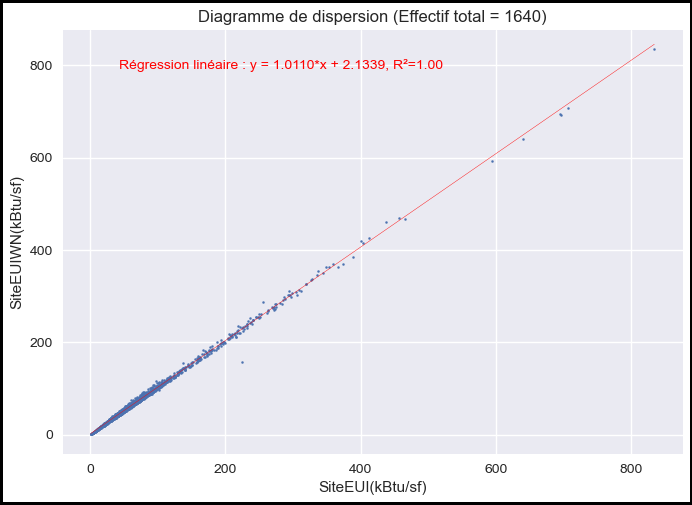

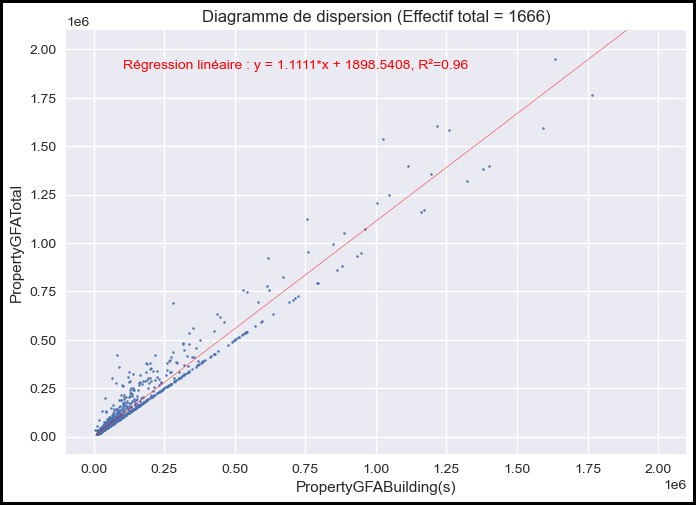

In [149]:
scatter_plot(ser_x=df1['NaturalGas(kBtu)'], ser_y=df1['NaturalGas(therms)'], max_x=4e7, max_y=4e5)
scatter_plot(ser_x=df1['Electricity(kBtu)'], ser_y=df1['Electricity(kWh)'], max_x=7e7, max_y=2.5e7)
scatter_plot(ser_x=df1['SiteEnergyUse(kBtu)'], ser_y=df1['SiteEnergyUseWN(kBtu)'], max_x=1e8, max_y=1e8)
scatter_plot(ser_x=df1['SourceEUI(kBtu/sf)'], ser_y=df1['SourceEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)'], ser_y=df1['SiteEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df1['PropertyGFABuilding(s)'], ser_y=df1['PropertyGFATotal'], max_x=2e6, max_y=2e6)

### Autres scatter plots

## Latitude / longitude

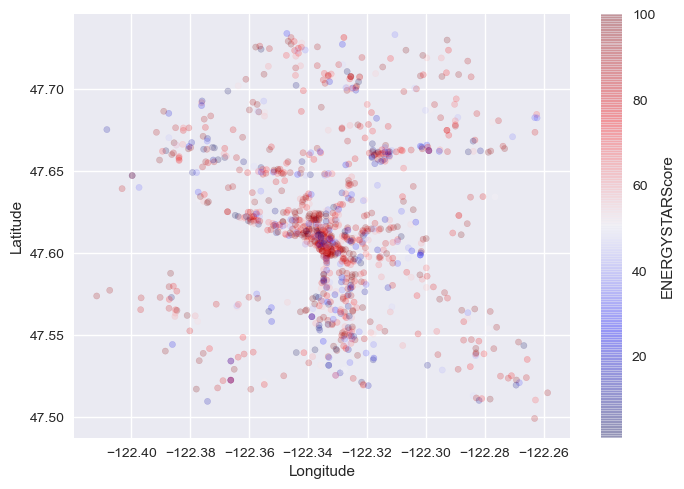

In [145]:
df1.plot(kind="scatter", x="Longitude", y="Latitude", c='ENERGYSTARScore', label=None, cmap=plt.get_cmap("seismic"), alpha=0.2);

## Conclusions sur l'analyse exploratoire

### Variables WN (weather normalized)

Elles prennent trop souvent la valeur zéro.  
Après suppression des valeurs fausses zéro, la corrélation avec leur équivalent non WN est très élevée.  
Ces variables ne sont donc pas utilisées pour le modèle prédictif.

# Sauvegarde du df nettoyé

In [146]:
df1.to_pickle('df_après_nettoyage_Projet_élec.pkl')

Pour le modèle prédictif, on ne retient que les variables suivantes :  
    - set_var_quanti_conservees  
    - set_var_quali

# Feature engineering

## Vérifications de routine

### Somme des surfaces

### Somme des énergies consommées

## Surface au sol

Les pertes énergétiques des bâtiments avec une forte surface de contact avec l'extérieur seront plus importantes que celles des bâtiments avec une faible surface de contact.  
Sur la base des données disponibles, on ne pourra pas calculer cette surface.  
Toutefois on peut calculer la surface au sol des bâtiments. C'est un bon proxy de la surface de contact totale pour les bâtiments à peu d'étages.

Surface_au_sol(sf) = PropertyGFABuilding(s) / NumberofFloors 


In [173]:
set(df1.columns) - set_var_quanti_conservees

{'BuildingType',
 'Electricity(kWh)',
 'LargestPropertyUseType',
 'NaturalGas(therms)',
 'Neighborhood',
 'PrimaryPropertyType',
 'PropertyGFATotal',
 'SecondLargestPropertyUseType',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUIWN(kBtu/sf)',
 'ThirdLargestPropertyUseType'}